In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

from graspologic.embed import AdjacencySpectralEmbed
from graspologic.simulations import sbm
from graspologic.plot import heatmap, pairplot

import warnings
warnings.filterwarnings('ignore')
np.random.seed(8889)
%matplotlib inline

/Users/tongqi/miniforge3/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/tongqi/miniforge3/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/tongqi/miniforge3/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDeprecatio

In [2]:
import networkx as nx
from scipy.sparse import csr_array
from graspologic.simulations import rdpg
#from scipy.linalg import irlba
#from scipy.spatial import procrustes
%run GraphEncoder.ipynb
import leidenalg as la
import igraph as ig
import scipy.sparse as sp
import random
import math
import seaborn as sns

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from gae.layers import GraphConvolution
from gae.model import GCNModelVAE
from gae.utils import load_data, mask_test_edges, preprocess_graph, get_roc_score
from gae.optimizer import loss_function


In [4]:
# Define a function for dot product sampling
def sample_dot_product(lpvs):
        num_nodes = lpvs.shape[1]
        similarity_matrix = np.dot(lpvs.T, lpvs)
        np.fill_diagonal(similarity_matrix, 0)  # Remove self-similarity
        return nx.Graph(similarity_matrix)

def adj_to_edg(A):
    """
      input is the symmetric adjacency matrix: A
      other variables in this function:
      s: number of edges
      return edg_list -- matrix format with shape(edg_sum,3):
      example row in edg_list(matrix): [vertex1, vertex2, connection weight from Adj matrix]
    """
    # check the len of the second dimenson of A
    if A.shape[1] <= 3:
      edg = A
    else:
      n = A.shape[0]
      # construct the initial edgg_list matrix with the size of (edg_sum, 3)
      edg_list = []
      for i in range(n):
        for j in range(i, n):
          if A[i,j] > 0:
            row = [i, j, A[i,j]]
            edg_list.append(row)
      edg = np.array(edg_list)
    return edg

def procrustes(X, Y, type="I"):
    if type == "C":
        X = X / np.linalg.norm(X, ord="fro") * np.sqrt(X.shape[0])
        Y = Y / np.linalg.norm(Y, ord="fro") * np.sqrt(Y.shape[0])
    if type == "D":
        tX = np.sum(X ** 2, axis=1)
        tX[tX <= 1e-15] = 1
        tY = np.sum(Y ** 2, axis=1)
        tY[tY <= 1e-15] = 1
        X = X / np.sqrt(tX)[:, np.newaxis]
        Y = Y / np.sqrt(tY)[:, np.newaxis]

    tmp = X.T @ Y
    U, s, Vt = np.linalg.svd(tmp,full_matrices=True)
    W = U @ Vt
    error = np.linalg.norm(X @ W - Y, ord="fro")
    
    return {"error": error, "W": W}

def ARDPG(n,k):
    A = np.zeros((n,n))
    X = np.random.uniform(0.0, 1.0, (n,1))
    for i in range(0,n):
        if y[i] == 1:
            X[i,:] = np.random.beta(1,3)
        elif y[i] == 2:
            X[i,:] = np.random.beta(3,3)
        else:
            X[i,:] = np.random.beta(3,1)
    P=np.matmul(X,X.transpose())
    for i in range(0,n):
        for j in range(1,n):
            A[i,j]=np.random.binomial(1,P[i,j])
    for i in range(0,n):
        for j in range(0,i):
            A[i,j] = A[j,i]
            A[i,i]=0
    return A

def gety(n):
    y = np.zeros((n,1))
    #np.random.seed(2)
    for i in range(0,n):
        y[i,0] = np.random.choice(np.arange(1, 4), p=[0.2, 0.3,0.5])
    return(y)

def latent3y(n):
    X1 = np.random.dirichlet((2,1,1),int(n/3))
    X2 = np.random.dirichlet((1,1,2),int(n/3))
    X3 = np.random.dirichlet((1,2,1),(n-int(n/3)*2))
    together = np.concatenate((X1, X2,X3))
    latent = np.delete(together, 2, 1)
    ty = [1,2,3]
    y = np.repeat(ty, n/3)
    return(latent,y)
  


In [5]:
def GCN_emb(model, features, adj_norm_matrix, adj_label,n, decay,learning_rate, epochs = 200):
    optimizer = torch.optim.Adam(
      model.parameters(),
      lr=learning_rate,
      weight_decay=decay) #weight decay is important!

    # get class weight
    pos_weight = ((adj_label.shape[0] * adj_label.shape[0] - adj_label.sum()) / adj_label.sum())
    # get adj norm
    adj_norm = adj_label.shape[0] * adj_label.shape[0] / float((adj_label.shape[0] *adj_label.shape[0] - adj_label.sum()) * 2)

    # Training the VAE   
    while True: #we can try 20 different random weight init runs to get an average 
        # initialize weights randomly => impact on convergence
        model.gc1.reset_parameters()
        model.gc2.reset_parameters()
        model.gc3.reset_parameters()  
        # Training
        for epoch in range(0, epochs + 1):
            model.train()
            optimizer.zero_grad()
            # ===================forward=====================
            adj_hat, mu, logvar = model(features,adj_norm_matrix)        
            loss = loss_function(adj_hat,adj_label,mu,logvar,n,adj_norm,pos_weight) #might reduce the KL term regularization
            # log
            if epoch == 0:
              init_loss = loss.item()
            # if epoch% 50 == 0:
            #   print('loss: ', loss.item())
            # ===================backward====================
            loss.backward()
            optimizer.step()
        # Check convergence
        if (init_loss-loss.item())/loss.item() > 0.05: 
            break
        else:
          print(model)
          print('not converged yet, reset params and rerun')

  # Get GCN embedding
    with torch.no_grad():
      model.eval()
      adj_hat, mu, logvar = model(features, adj_norm_matrix)
      z = model.reparameterize(mu, logvar) 

    return z

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def preprocess_graph(adj_):
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten()) #D^-0.5
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()  #D^-0.5 A D^-0.5
    return sparse_mx_to_torch_sparse_tensor(adj_normalized), sparse_mx_to_torch_sparse_tensor(adj_)

def adj_in_out(adj):
    row, col = np.where(adj)
    coo = np.rec.fromarrays([row, col, adj[row, col]], names='row col value'.split())
    out = sp.coo_matrix((coo['value'], (coo['row'], coo['col'])), (adj.shape[0], adj.shape[1]))
    #Adjacency normalized matrix and label for GVAE usage
    adj_norm_matrix, adj_matrix = preprocess_graph(out)
    adj_label = torch.FloatTensor(out.toarray())
    return adj_norm_matrix, adj_matrix, adj_label#, out

In [571]:
######
### CAUTION DO not RUN
import os
os.makedirs('./sim_data', exist_ok=True)
os.makedirs('./plots', exist_ok=True)

In [6]:
opt = la.Optimiser()
opt.consider_empty_community = False

## RDPG with no clusters

In [20]:
# CAUTION
# with normalized
# no cluster
# first vertices and randomly selected points
# clean code

nvs = np.arange(100, 1501, 200)

sim = 50
random.seed(118)

ASE_dist = []
ASE_nml = []
GEE_dist = []
GEE_nml = []
GAE_dist = []
GAE_nml = []
n_vs = []

GEE_fnorm = []
GAE_fnorm = []

GEE_dist2 = []
GEE_fnorm2=[]

adj0_norms = []

sim_alldata_nml = []

for n in nvs:
    for i in range(sim):
        lpvs = np.random.dirichlet((1,1,1),n) 
        lpvs = np.delete(lpvs, 2, 1)
        g = rdpg(lpvs,loops=False)
        g.astype(int)
        adj0 = csr_array(g)
        graph0 = nx.from_numpy_matrix(g,parallel_edges=False, create_using=None)
        
        adj0_norm = sp.linalg.norm(adj0)
        adj0_norms.append(adj0_norm)

        ########## change clique size ##################################
        ratio = 0.2      
        cliquesize =f'n^34'      #!!    f'{ratio}*n'
        clique_size = n**(3/4)   #math.log(n)           #   ratio*n 
        num_vertices = int(clique_size) 
        #################  change location of vertices##################
        #c_vertices = np.arange(0,num_vertices)  
        #c_vertices = np.arange(n-num_vertices,n)  
        c_vertices = random.sample(range(0,n),num_vertices)
        ################################################################
        full_g = nx.complete_graph(c_vertices)
        
        full_edges = list(full_g.edges())
        edges = list(graph0.edges()) 
        all_edges = set(full_edges).union(set(edges))
        

        graph1 = nx.Graph()
        graph1.add_nodes_from(sorted(graph0.nodes(data=True)))
        graph1.add_edges_from(all_edges)
        

        adj1 = nx.to_numpy_array(graph1, dtype=int)

        ##############  ASE  ######################3
        d = 2
        ase = AdjacencySpectralEmbed(n_components=d, algorithm='truncated')
        ASE_Xhat0 = ase.fit_transform(adj0)

        ASE_Xhat1 = ase.fit_transform(adj1)

        #pairplot(Xhat0, title='2-component embedding', height=2)
        ASE_d = procrustes(ASE_Xhat1,ASE_Xhat0)
        ASE_d = ASE_d['error']
        ASE_dist.append(ASE_d)
        
        ASE_n = ASE_d/adj0_norm
        ASE_nml.append(ASE_n)

        ############ GEE ##################
        edgelist0 = adj_to_edg(adj0)
        i_graph0 = ig.Graph.from_networkx(graph0)
        y0 = la.find_partition(i_graph0, la.ModularityVertexPartition)
        #y0 = la.find_partition(i_graph0,la.CPMVertexPartition,resolution_parameter = 0.015)
        label_num = []
        for k in range(len(y0)):
            y = len(y0[k])
            label_num.append(y)
        values = np.arange(len(label_num))
        label0 = np.repeat(values, label_num) 
        label0= label0.reshape((n,1))
        Z0,W0 = graph_encoder_embed(edgelist0,label0,n,correlation=False)

        edgelist1 = adj_to_edg(adj1)
        i_graph1 = ig.Graph.from_networkx(graph1)
        n_comms = len(label_num)
        y1 = la.CPMVertexPartition(i_graph1,initial_membership=np.random.choice(n_comms, n),
                           resolution_parameter=0.5)
        
        label_num1 = []
        for j in range(len(y1)):
            y = len(y1[j])
            label_num1.append(y)
        values1 = np.arange(len(label_num1))
        label1 = np.repeat(values1, label_num1) 
        label1= label1.reshape((n,1))
        Z1,W1 = graph_encoder_embed(edgelist1,label1,n,correlation=False) #!!!!!!!!!!!!!!!!

        GEE_d = procrustes(Z1,Z0)
        GEE_d = GEE_d['error']
        GEE_dist.append(GEE_d)
        
        GEE_n = GEE_d/adj0_norm
        GEE_nml.append(GEE_n)
        
        GEE_fd = np.linalg.norm(Z0 - Z1, "fro")
        GEE_fnorm.append(GEE_fd)
        
        y000 = la.find_partition(i_graph0,la.CPMVertexPartition,resolution_parameter = 0.4)
        label_numppp = []
        for k in range(len(y000)):
            y = len(y000[k])
            label_numppp.append(y)
        values = np.arange(len(label_numppp))
        label000 = np.repeat(values, label_numppp) 
        label000= label000.reshape((n,1))
        Z000,W000 = graph_encoder_embed(edgelist0,label000,n,correlation=False)#,emb_opt='AEE')

        edgelist1 = adj_to_edg(adj1)
        i_graph1 = ig.Graph.from_networkx(graph1)
        n_comms = len(label_numppp)
        y111 = la.CPMVertexPartition(i_graph1,initial_membership=np.random.choice(n_comms, n),
                           resolution_parameter=0.5)
        
        label_num1ttt = []
        for j in range(len(y111)):
            y = len(y111[j])
            label_num1ttt.append(y)
        values1 = np.arange(len(label_num1ttt))
        label111 = np.repeat(values1, label_num1ttt) 
        label111= label111.reshape((n,1))
        Z111,W111 = graph_encoder_embed(edgelist1,label111,n,correlation=False) #!!!!!!!!!!!!!!!!!!!!
        
        GEE_dd = procrustes(Z111,Z000)
        GEE_dd = GEE_dd['error']
        GEE_dist2.append(GEE_dd)

        GEE_fd2 = np.linalg.norm(Z000 - Z111, "fro")
        GEE_fnorm2.append(GEE_fd2)
        
        
        ############### VGAE ################
        dim = d
        features = torch.eye(n)
        model_GAE = GCNModelVAE(n, 2*dim, dim, 0) #init new instance everytime. Can change 0 to other dropout rates
        
        adj0 = nx.to_numpy_array(graph0, dtype=int)
        adj_norm_matrix0, adj_matrix0, adj_label0 = adj_in_out(adj0)
        GAE_0 = GCN_emb(model_GAE, features, adj_norm_matrix0, adj_label0,n,decay=0, learning_rate=1e-2) #initial benchmark: decay = 1e-3; investigate 0 weight decay w/ dropout on 
        GAE_0 = GAE_0.numpy()
        adj1 = nx.to_numpy_array(graph1, dtype=int)
        adj_norm_matrix1, adj_matrix1, adj_label1 = adj_in_out(adj1)
        GAE_1 = GCN_emb(model_GAE, features, adj_norm_matrix1, adj_label1,n,decay=0, learning_rate=1e-2) #initial benchmark: decay = 1e-3; investigate 0 weight decay w/ dropout on 
        GAE_1 = GAE_1.numpy()
        GAE_d = procrustes(GAE_1,GAE_0)
        GAE_d = GAE_d['error']
        GAE_dist.append(GAE_d)
        
        GAE_n = GAE_d/adj0_norm
        GAE_nml.append(GAE_n)
        
        GAE_fd = np.linalg.norm(GAE_0 - GAE_1, "fro")
        GAE_fnorm.append(GAE_fd)
        
        n_vs.append(n)
        
           
    sim_data = np.column_stack((ASE_dist, GEE_dist,GAE_dist,
                                ASE_nml,GEE_nml,GAE_nml,n_vs,
                                GEE_fnorm,GAE_fnorm,GEE_dist2,GEE_fnorm2,adj0_norms))
    sim_data = pd.DataFrame(sim_data, columns = ['ASE_dist','GEE_dist','VGAE_dist',
                                                 'ASE_nml','GEE_nml','GAE_nml','n',
                                                 'GEE_fnorm','VGAE_Fnorm','GEE_dist2','GEE_fnorm2','adj0_norms'])
    
    df_id = n.astype(str)
    sim_data.to_csv("./sim_data/new_sim/rdpgnocluster_n^34"+cliquesize+df_id+".csv", sep=',', index=False)
    
sim_alldata_nml.append(sim_data)


#print(sim_alldata_nml)



GCNModelVAE(
  (gc1): GraphConvolution (100 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (100 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (100 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (100 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (100 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphCon

GCNModelVAE(
  (gc1): GraphConvolution (1500 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (1500 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (1500 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (1500 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (1500 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun


In [21]:
# CAUTION 
# read dataset and draw
# clean code for RDPG
readdata = pd.read_csv ('./sim_data/new_sim/rdpgnocluster_n^34n^341500.csv',sep=',',header = 0)
print(readdata.head(3))

distdf = readdata[['ASE_dist','GEE_dist','n','VGAE_Fnorm','GEE_dist2']]
meltdf = pd.melt(distdf, id_vars=['n'], var_name='variable', value_name='value')
summary_functions = {'value': ['min', 'mean', 'max', 'std']}
finaldf = meltdf.groupby(['n', 'variable']).agg(summary_functions)
finaldf.columns = ['_'.join(col).strip() for col in finaldf.columns.values]
finaldf.reset_index(inplace=True)


   ASE_dist  GEE_dist  VGAE_dist   ASE_nml   GEE_nml   GAE_nml      n  \
0  5.155578  3.136616   2.623231  0.111814  0.068027  0.056892  100.0   
1  4.910917  3.933199   5.013548  0.103211  0.082662  0.105368  100.0   
2  4.771743  3.650620   2.323618  0.104527  0.079968  0.050900  100.0   

   GEE_fnorm  VGAE_Fnorm  GEE_dist2  GEE_fnorm2  adj0_norms  
0   3.517180    7.689134   7.063213   10.063786   46.108568  
1   5.086393    5.023317   7.197095   10.193227   47.581509  
2   4.398832    5.606668   6.655983   10.219561   45.650849  


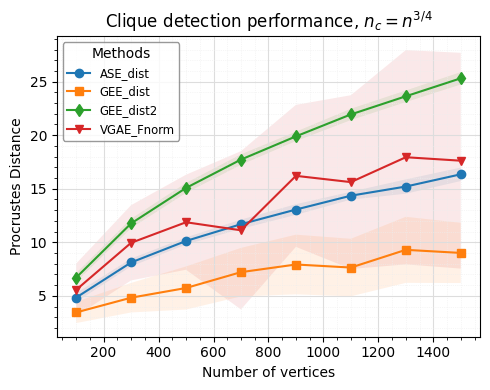

In [23]:
# CAUTION

fig, ax = plt.subplots(figsize=(5, 4))
#fig.patch.set_facecolor("#fafafa")
#ax.set_facecolor("#fafafa")

for item in [fig, ax]:
    item.patch.set_visible(True)

for variable, group in finaldf.groupby('variable'):
    ax.plot(group['n'], group['value_mean'], label=variable)
    ax.fill_between(group['n'], group['value_mean'] - group['value_std'], 
                    group['value_mean'] + group['value_std'], alpha=0.1)
    ax.grid(True)
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.minorticks_on()
    

ax.set(xlabel='Number of vertices', ylabel='Procrustes Distance', 
       title='Clique detection performance, $n_c = n^{3/4}$')#+cliquesize)
# ax.set_facecolor("white")

# set markers
markers = ['o', 's', 'd','v']
#markers = ['o', 's', 'd']
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])

#ax.legend(ax.get_lines(), finaldf.columns, loc='upper left', ncol=2)

plt.tight_layout()

legend = plt.legend(frameon = 1,loc = 2,title="Methods",fontsize='small',fancybox=True )
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')

#plt.show()
#plt.savefig('./plots/newplots2/rdpg_n^34.png') #+ cliquesize + '.png')


In [366]:
# CAUTION 
# read dataset and draw
# clean code for 3 cluster RDPG
readdata = pd.read_csv ('./sim_data/rdpg3cluster_lognlog(n)1500.csv',sep=',',header = 0)
print(readdata.head(3))

distdf = readdata[['ASE_dist','GEE_dist','n','VGAE_Fnorm']]
meltdf = pd.melt(distdf, id_vars=['n'], var_name='variable', value_name='value')
summary_functions = {'value': ['min', 'mean', 'max', 'std']}
finaldf = meltdf.groupby(['n', 'variable']).agg(summary_functions)
finaldf.columns = ['_'.join(col).strip() for col in finaldf.columns.values]
finaldf.reset_index(inplace=True)


   ASE_dist  GEE_dist  VGAE_dist   ASE_nml   GEE_nml   GAE_nml      n  \
0  6.429475  3.741065   1.154845  0.133485  0.077670  0.023976  100.0   
1  5.876256  4.367942   0.994954  0.128169  0.095271  0.021701  100.0   
2  6.246256  4.227932   1.229108  0.134585  0.091097  0.026483  100.0   

   GEE_fnorm  VGAE_Fnorm  
0   4.542036    4.485688  
1   5.103937    3.905960  
2   4.609610    4.652711  


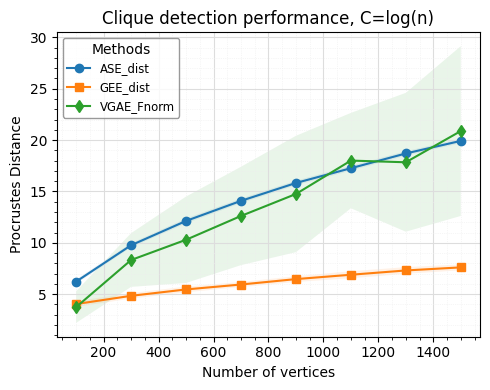

In [368]:
# CAUTION

fig, ax = plt.subplots(figsize=(5, 4))
#fig.patch.set_facecolor("#fafafa")
#ax.set_facecolor("#fafafa")

for item in [fig, ax]:
    item.patch.set_visible(True)

for variable, group in finaldf.groupby('variable'):
    ax.plot(group['n'], group['value_mean'], label=variable)
    ax.fill_between(group['n'], group['value_mean'] - group['value_std'], 
                    group['value_mean'] + group['value_std'], alpha=0.1)
    ax.grid(True)
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.minorticks_on()
    

ax.set(xlabel='Number of vertices', ylabel='Procrustes Distance', title='Clique detection performance, C='+cliquesize)


# set markers
#markers = ['o', 's', 'd','v','x','8']
markers = ['o', 's', 'd','v']
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])

#ax.legend(ax.get_lines(), finaldf.columns, loc='upper left', ncol=2)

plt.tight_layout()

legend = plt.legend(frameon = 1,loc = 2,title="Methods",fontsize='small',fancybox=True )
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')

#plt.show()
#plt.savefig('./plots/rdpg3_logn.png')# + cliquesize + '.png')


## Try the 3 cluster RDPG

In [14]:
def ARDPG(n,k):
    A = np.zeros((n,n))
    X = np.random.uniform(0.0, 1.0, (n,1))
    for i in range(0,n):
        if y[i] == 1:
            X[i,:] = np.random.beta(1,3)
        elif y[i] == 2:
            X[i,:] = np.random.beta(3,3)
        else:
            X[i,:] = np.random.beta(3,1)
    P=np.matmul(X,X.transpose())
    for i in range(0,n):
        for j in range(1,n):
            A[i,j]=np.random.binomial(1,P[i,j])
    for i in range(0,n):
        for j in range(0,i):
            A[i,j] = A[j,i]
            A[i,i]=0
    return A

def gety(n):
    y = np.zeros((n,1))
    #np.random.seed(2)
    for i in range(0,n):
        y[i,0] = np.random.choice(np.arange(1, 4), p=[0.2, 0.3,0.5])
    return(y)

def latent3y(n):
    X1 = np.random.dirichlet((2,1,1),int(n/3))
    X2 = np.random.dirichlet((1,1,2),int(n/3))
    X3 = np.random.dirichlet((1,2,1),(n-int(n/3)*2))
    together = np.concatenate((X1, X2,X3))
    latent = np.delete(together, 2, 1)
    ty = [1,2,3]
    y = np.repeat(ty, n/3)
    return(latent,y)
  

## RDPG with 3 clusters

In [74]:
# CAUTION
# with normalized
# 3 cluster RDPG
# frist vertices

nvs = np.arange(100, 1501, 200)
d = 3
sim = 50
random.seed(118)

ASE_dist = []
ASE_nml = []
GEE_dist = []
GEE_nml = []
GAE_dist = []
GAE_nml = []
n_vs = []
#sim_alldata = pd.DataFrame()
sim_alldata_nml = []

for n in nvs:
    for i in range(sim):
        #lpvs = np.random.normal(size=(latent, n))
        #lpvs_normalized = np.apply_along_axis(lambda x: np.abs(x) / np.sqrt(np.sum(x**2)), axis=0, arr=lpvs)
        #lpvs = np.random.dirichlet((1,1,1),n) ### 
        #lpvs = np.delete(lpvs, 2, 1)
        latent, ys = latent3y(n)
        g = rdpg(latent,loops=False)
        # _ = heatmap(g, title='A random RDPG')
        g.astype(int)
        adj0 = csr_array(g)
        graph0 = nx.from_numpy_matrix(g,parallel_edges=False, create_using=None)
        
        # get the norm of adj0
        adj0_norm = sp.linalg.norm(adj0)

        # Generate a complete graph for the first log(n[k])^2 vertices
        ########## change clique size
        ratio = 0.2      
        cliquesize = f'log(n)^2'    #!!       f'{ratio}*n'
        clique_size = math.log(n)**2        ###     ratio*n   
        num_vertices = int(clique_size) ########## change clique size
        full_g = nx.complete_graph(num_vertices)
        
        # Get the edges of the complete graph
        full_edges = list(full_g.edges())
        edges = list(graph0.edges()) 
        all_edges = set(full_edges).union(set(edges))
        # Create a graph from the merged edges
        #graph1 = nx.Graph(all_edges)
        graph1 = nx.compose(full_g,graph0)

        # Convert the graph to an adjacency matrix
        adj1 = nx.to_numpy_array(graph1, dtype=int)

        #%%%%%%%%%%%% ASE
        d = 3
        ase = AdjacencySpectralEmbed(n_components=d, algorithm='truncated')
        ASE_Xhat0 = ase.fit_transform(adj0)
        #ASE_Xhat0
        ASE_Xhat1 = ase.fit_transform(adj1)
        #ASE_Xhat1
        #pairplot(Xhat0, title='2-component embedding', height=2)
        ASE_d = procrustes(ASE_Xhat1,ASE_Xhat0)
        ASE_d = ASE_d['error']
        ASE_dist.append(ASE_d)
        
        ASE_n = ASE_d/adj0_norm
        ASE_nml.append(ASE_n)

        #%%%%%%%%%% GEE
        n_comms = 3
        edgelist0 = adj_to_edg(adj0)
        i_graph0 = ig.Graph.from_networkx(graph0)
        y0 = la.CPMVertexPartition(i_graph0,initial_membership=np.random.choice(n_comms, n),
                           resolution_parameter=0.5)
#         y0 = leidenalg.find_partition(i_graph0, leidenalg.ModularityVertexPartition)
        label_num = []
        for k in range(len(y0)):
            y = len(y0[k])
            label_num.append(y)
        values = np.arange(len(label_num))
        label0 = np.repeat(values, label_num) 
        label0= label0.reshape((n,1))
        Z0,W0 = graph_encoder_embed(edgelist0,label0,n,correlation=False,emb_opt='AEE')

        edgelist1 = adj_to_edg(adj1)
        i_graph1 = ig.Graph.from_networkx(graph1)
#         n_comms = len(label_num)
        y1 = la.CPMVertexPartition(i_graph1,initial_membership=np.random.choice(n_comms, n),
                           resolution_parameter=0.5)
        #y1 = leidenalg.find_partition(i_graph1, leidenalg.ModularityVertexPartition)
        label_num1 = []
        for j in range(len(y1)):
            y = len(y1[j])
            label_num1.append(y)
        values1 = np.arange(len(label_num1))
        label1 = np.repeat(values1, label_num1) 
        label1= label1.reshape((n,1))
        Z1,W1 = graph_encoder_embed(edgelist1,label1,n,correlation=False,emb_opt='AEE')

        GEE_d = procrustes(Z1,Z0)
        GEE_d = GEE_d['error']
        GEE_dist.append(GEE_d)
        
        GEE_n = GEE_d/adj0_norm
        GEE_nml.append(GEE_n)
        
        
        #%%%%%%%%%%%%%%%%% GAE
        dim = d
        features = torch.eye(n)
        model_GAE = GCNModelVAE(n, 2*dim, dim, 0) #init new instance everytime. Can change 0 to other dropout rates
        
        adj0 = nx.to_numpy_array(graph0, dtype=int)
        adj_norm_matrix0, adj_matrix0, adj_label0 = adj_in_out(adj0)
        GAE_0 = GCN_emb(model_GAE, features, adj_norm_matrix0, adj_label0,n,decay=0, learning_rate=1e-2) #initial benchmark: decay = 1e-3; investigate 0 weight decay w/ dropout on 
        GAE_0 = GAE_0.numpy()
        adj1 = nx.to_numpy_array(graph1, dtype=int)
        adj_norm_matrix1, adj_matrix1, adj_label1 = adj_in_out(adj1)
        GAE_1 = GCN_emb(model_GAE, features, adj_norm_matrix1, adj_label1,n,decay=0, learning_rate=1e-2) #initial benchmark: decay = 1e-3; investigate 0 weight decay w/ dropout on 
        GAE_1 = GAE_1.numpy()
        GAE_d = procrustes(GAE_1,GAE_0)
        GAE_d = GAE_d['error']
        GAE_dist.append(GAE_d)
        
        GAE_n = GAE_d/adj0_norm
        GAE_nml.append(GAE_n)
        
        n_vs.append(n)
        
           
    sim_data = np.column_stack((ASE_dist, GEE_dist,GAE_dist,
                                ASE_nml,GEE_nml,GAE_nml,n_vs))
    sim_data = pd.DataFrame(sim_data, columns = ['ASE_dist','GEE_dist','GAE_dist',
                                                 'ASE_nml','GEE_nml','GAE_nml','n'])
    
    df_id = n.astype(str)
    #sim_data.to_csv("./sim_data/sim_data_nml_dirichlet3rdpglog2"+cliquesize+df_id+".csv", sep=',', index=False)
    
sim_alldata_nml.append(sim_data)


#print(sim_alldata_nml)



GCNModelVAE(
  (gc1): GraphConvolution (500 -> 6)
  (gc2): GraphConvolution (6 -> 3)
  (gc3): GraphConvolution (6 -> 3)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (500 -> 6)
  (gc2): GraphConvolution (6 -> 3)
  (gc3): GraphConvolution (6 -> 3)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (900 -> 6)
  (gc2): GraphConvolution (6 -> 3)
  (gc3): GraphConvolution (6 -> 3)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (900 -> 6)
  (gc2): GraphConvolution (6 -> 3)
  (gc3): GraphConvolution (6 -> 3)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (900 -> 6)
  (gc2): GraphConvolution (6 -> 3)
  (gc3): GraphConvolution (6 -> 3)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphCon

In [61]:
print(sim_alldata_nml)

[     ASE_dist   GEE_dist   GAE_dist   ASE_nml   GEE_nml   GAE_nml       n
0    0.249236  13.973512   0.523956  0.005323  0.298459  0.011191   100.0
1    0.447170  15.440426   2.693231  0.009419  0.325224  0.056728   100.0
2    0.169667  14.848233   1.269111  0.003526  0.308536  0.026371   100.0
3    0.345812  15.131404   1.904388  0.007664  0.335344  0.042205   100.0
4    0.355205  15.152770   0.860214  0.007150  0.305014  0.017315   100.0
..        ...        ...        ...       ...       ...       ...     ...
395  0.079362  55.893732  24.913204  0.000113  0.079370  0.035377  1500.0
396  0.045187  57.625359  26.421291  0.000064  0.081633  0.037429  1500.0
397  0.047219  57.501985  29.350922  0.000067  0.081276  0.041486  1500.0
398  0.096564  57.060841  29.001255  0.000138  0.081327  0.041335  1500.0
399  0.030423  57.196578  14.674850  0.000043  0.081364  0.020876  1500.0

[400 rows x 7 columns]]


## RDPG with 3 clusters, randomly selected vertices

In [15]:
# CAUTION
# with normalized
# 3 cluster RDPG
##### with randomly select vertices 

nvs = np.arange(100, 1501, 200)
d = 3
sim = 50
random.seed(118)

ASE_dist = []
ASE_nml = []
GEE_dist = []
GEE_nml = []
VGAE_dist = []
VGAE_nml = []
n_vs = []

GEE_fnorm = []
GAE_fnorm = []

#sim_alldata = pd.DataFrame()
sim_alldata_nml = []

for n in nvs:
    for i in range(sim):
        #lpvs = np.random.normal(size=(latent, n))
        #lpvs_normalized = np.apply_along_axis(lambda x: np.abs(x) / np.sqrt(np.sum(x**2)), axis=0, arr=lpvs)
        #lpvs = np.random.dirichlet((1,1,1),n) ### 
        #lpvs = np.delete(lpvs, 2, 1)
        latent, ys = latent3y(n)
        g = rdpg(latent,loops=False)
        # _ = heatmap(g, title='A random RDPG')
        g.astype(int)
        adj0 = csr_array(g)
        graph0 = nx.from_numpy_matrix(g,parallel_edges=False, create_using=None)
        
        # get the norm of adj0
        adj0_norm = sp.linalg.norm(adj0)

        # Generate a complete graph for the first log(n[k])^2 vertices
        ########## change clique size
        ratio = 0.2      
        cliquesize = f'sqrtn'   #!!         f'log(n)' 
        clique_size = math.sqrt(n)        ###        math.log(n)
        num_vertices = int(clique_size) ########## change clique size
        c_vertices = random.sample(range(0,n),num_vertices) # randomly select vertices to form clique
        
        full_g = nx.complete_graph(c_vertices)
        
        # Get the edges of the complete graph
        full_edges = list(full_g.edges())
        edges = list(graph0.edges()) 
        all_edges = set(full_edges).union(set(edges))
        # Create a graph from the merged edges
        #graph1 = nx.compose(full_g,graph0)
        graph1 = nx.Graph(all_edges)
        graph1.add_nodes_from(list(graph0.nodes- graph1.nodes))

        # Convert the graph to an adjacency matrix
        adj1 = nx.to_numpy_array(graph1, dtype=int)

        #%%%%%%%%%%%% ASE
        d = 3
        ase = AdjacencySpectralEmbed(n_components=d, algorithm='truncated')
        ASE_Xhat0 = ase.fit_transform(adj0)
        #ASE_Xhat0
        ASE_Xhat1 = ase.fit_transform(adj1)
        #ASE_Xhat1
        #pairplot(Xhat0, title='2-component embedding', height=2)
        ASE_d = procrustes(ASE_Xhat1,ASE_Xhat0)
        ASE_d = ASE_d['error']
        ASE_dist.append(ASE_d)
        
        ASE_n = ASE_d/adj0_norm
        ASE_nml.append(ASE_n)

        #%%%%%%%%%% GEE
        n_comms = 3
        edgelist0 = adj_to_edg(adj0)
        i_graph0 = ig.Graph.from_networkx(graph0)
        y0 = la.CPMVertexPartition(i_graph0,initial_membership=np.random.choice(n_comms, n),
                           resolution_parameter=0.5)
#         y0 = leidenalg.find_partition(i_graph0, leidenalg.ModularityVertexPartition)
        label_num = []
        for k in range(len(y0)):
            y = len(y0[k])
            label_num.append(y)
        values = np.arange(len(label_num))
        label0 = np.repeat(values, label_num) 
        label0= label0.reshape((n,1))
        Z0,W0 = graph_encoder_embed(edgelist0,label0,n,correlation=False,emb_opt='AEE')

        edgelist1 = adj_to_edg(adj1)
        i_graph1 = ig.Graph.from_networkx(graph1)
#         n_comms = len(label_num)
        y1 = la.CPMVertexPartition(i_graph1,initial_membership=np.random.choice(n_comms, n),
                           resolution_parameter=0.5)
        #y1 = leidenalg.find_partition(i_graph1, leidenalg.ModularityVertexPartition)
        label_num1 = []
        for j in range(len(y1)):
            y = len(y1[j])
            label_num1.append(y)
        values1 = np.arange(len(label_num1))
        label1 = np.repeat(values1, label_num1) 
        label1= label1.reshape((n,1))
        Z1,W1 = graph_encoder_embed(edgelist1,label1,n,correlation=False,emb_opt='AEE')

        GEE_d = procrustes(Z1,Z0)
        GEE_d = GEE_d['error']
        GEE_dist.append(GEE_d)
        
        GEE_n = GEE_d/adj0_norm
        GEE_nml.append(GEE_n)
        
        GEE_fd = np.linalg.norm(Z0 - Z1, "fro")
        GEE_fnorm.append(GEE_fd)
        
        
        #%%%%%%%%%%%%%%%%% GAE
        dim = d
        features = torch.eye(n)
        model_GAE = GCNModelVAE(n, 2*dim, dim, 0) #init new instance everytime. Can change 0 to other dropout rates
        
        adj0 = nx.to_numpy_array(graph0, dtype=int)
        adj_norm_matrix0, adj_matrix0, adj_label0 = adj_in_out(adj0)
        GAE_0 = GCN_emb(model_GAE, features, adj_norm_matrix0, adj_label0,n,decay=0, learning_rate=1e-2) #initial benchmark: decay = 1e-3; investigate 0 weight decay w/ dropout on 
        GAE_0 = GAE_0.numpy()
        adj1 = nx.to_numpy_array(graph1, dtype=int)
        adj_norm_matrix1, adj_matrix1, adj_label1 = adj_in_out(adj1)
        GAE_1 = GCN_emb(model_GAE, features, adj_norm_matrix1, adj_label1,n,decay=0, learning_rate=1e-2) #initial benchmark: decay = 1e-3; investigate 0 weight decay w/ dropout on 
        GAE_1 = GAE_1.numpy()
        GAE_d = procrustes(GAE_1,GAE_0)
        GAE_d = GAE_d['error']
        VGAE_dist.append(GAE_d)
        
        GAE_n = GAE_d/adj0_norm
        VGAE_nml.append(GAE_n)
        
        GAE_fd = np.linalg.norm(GAE_0 - GAE_1, "fro")
        GAE_fnorm.append(GAE_fd)
        
        n_vs.append(n)
        
           
    sim_data = np.column_stack((ASE_dist, GEE_dist,VGAE_dist,
                                ASE_nml,GEE_nml,VGAE_nml,n_vs,GEE_fnorm,GAE_fnorm))
    sim_data = pd.DataFrame(sim_data, columns = ['ASE_dist','GEE_dist','VGAE_dist',
                                                 'ASE_nml','GEE_nml','VGAE_nml','n','GEE_fnorm','VGAE_fnorm'])
    
    df_id = n.astype(str)
    sim_data.to_csv("./sim_data/new_sim/rdm_3rdpg_sqrtn"+cliquesize+df_id+".csv", sep=',', index=False)
    
sim_alldata_nml.append(sim_data)


#print(sim_alldata_nml)



GCNModelVAE(
  (gc1): GraphConvolution (300 -> 6)
  (gc2): GraphConvolution (6 -> 3)
  (gc3): GraphConvolution (6 -> 3)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (300 -> 6)
  (gc2): GraphConvolution (6 -> 3)
  (gc3): GraphConvolution (6 -> 3)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (500 -> 6)
  (gc2): GraphConvolution (6 -> 3)
  (gc3): GraphConvolution (6 -> 3)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (700 -> 6)
  (gc2): GraphConvolution (6 -> 3)
  (gc3): GraphConvolution (6 -> 3)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (700 -> 6)
  (gc2): GraphConvolution (6 -> 3)
  (gc3): GraphConvolution (6 -> 3)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphCon

In [19]:
# # CAUTION 
# # read dataset
# readdata = pd.read_csv ('./sim_data/new_sim/rdm_3rdpg_sqrtnsqrtn1500.csv',sep=',')
# #data = np.reshape(readdata, (sim*len(nvs), 7))
# #df = pd.DataFrame(data)
# distdf = readdata[['ASE_dist','GEE_dist','VGAE_dist','n']]
# meltdf = pd.melt(distdf, id_vars=['n'], var_name='variable', value_name='value')
# summary_functions = {'value': ['min', 'mean', 'max', 'std']}
# finaldf = meltdf.groupby(['n', 'variable']).agg(summary_functions)
# finaldf.columns = ['_'.join(col).strip() for col in finaldf.columns.values]
# finaldf.reset_index(inplace=True)
# #finaldf['D_R'] = finaldf['variable'].apply(lambda x: 'Dist' if x in ['GEE_dist', 'ASE_dist', 'GAE_dist'] else 'Normalized')

# # get sub-dataframe for the distance plot
# distdf = readdata[['ASE_dist','GEE_dist','VGAE_dist']]
# distdf.head(3)

# CAUTION 
# read dataset
readdata = pd.read_csv ('./sim_data/new_sim/rdm_3rdpg_sqrtnsqrtn1500.csv',sep=',',header = 0)

#df = pd.DataFrame(data)
#readdata.columns =['ASE_dist','GEE_dist','VGAE_dist','ASE_nml','GEE_nml','VGAE_nml','n','GAE_fnorm','GEE_fnorm']
distdf = readdata[['ASE_dist','GEE_dist','VGAE_dist','n','VGAE_fnorm','GEE_fnorm']]
meltdf = pd.melt(distdf, id_vars=['n'], var_name='variable', value_name='value')
summary_functions = {'value': ['min', 'mean', 'max', 'std']}
finaldf = meltdf.groupby(['n', 'variable']).agg(summary_functions)
finaldf.columns = ['_'.join(col).strip() for col in finaldf.columns.values]
finaldf.reset_index(inplace=True)

# get sub-dataframe for the distance plot
#distdf = readdata[['ASE_dist','GEE_dist','VGAE_dist']]
distdf.head(3)


,ASE_dist,GEE_dist,VGAE_dist,n,VGAE_fnorm,GEE_fnorm
0,5.936795,3.769806,0.401399,100.0,0.910064,4.907333
1,6.526409,3.869551,0.964654,100.0,3.663904,4.603747
2,6.014422,4.146332,1.077258,100.0,2.364750,4.854854


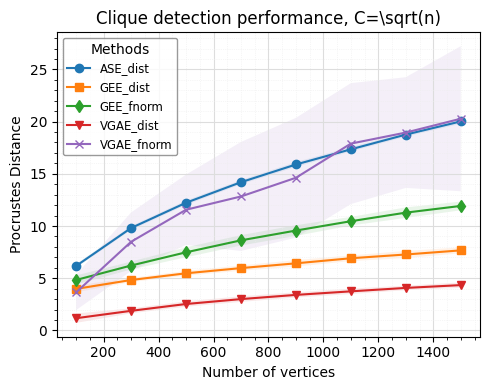

In [22]:
# CAUTION

fig, ax = plt.subplots(figsize=(5, 4))
#fig.patch.set_facecolor("#fafafa")
#ax.set_facecolor("#fafafa")

for item in [fig, ax]:
    item.patch.set_visible(True)

for variable, group in finaldf.groupby('variable'):
    ax.plot(group['n'], group['value_mean'], label=variable)
    ax.fill_between(group['n'], group['value_mean'] - group['value_std'], 
                    group['value_mean'] + group['value_std'], alpha=0.1)
    ax.grid(True)
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.minorticks_on()
    

ax.set(xlabel='Number of vertices', ylabel='Procrustes Distance', 
       title='Clique detection performance, C=\sqrt(n)')#+cliquesize)
# ax.set_facecolor("white")

# set markers
markers = ['o', 's', 'd','v','x','8']
#markers = ['o', 's', 'd']
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])

#ax.legend(ax.get_lines(), finaldf.columns, loc='upper left', ncol=2)

plt.tight_layout()

legend = plt.legend(frameon = 1,loc = 2,title="Methods",fontsize='small',fancybox=True )
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')

#plt.show()
#plt.savefig('./plots/rdm_diri_3rdpglogn' + cliquesize + '.png')


## RDPG with no clusters, randomly selected vertices

In [133]:
# CAUTION
# with normalized
# no cluster RDPG
##### with randomly select vertices 

nvs = np.arange(100, 1501, 200)
d = 2
sim = 50
random.seed(118)

ASE_dist = []
ASE_nml = []
GEE_dist = []
GEE_nml = []
VGAE_dist = []
VGAE_nml = []
n_vs = []

GEE_fnorm = []
GAE_fnorm = []

#sim_alldata = pd.DataFrame()
test_alldata_nml = []

for n in nvs:
    for i in range(sim):
        #lpvs = np.random.normal(size=(latent, n))
        #lpvs_normalized = np.apply_along_axis(lambda x: np.abs(x) / np.sqrt(np.sum(x**2)), axis=0, arr=lpvs)
        lpvs = np.random.dirichlet((1,1,1),n) ### 
        lpvs = np.delete(lpvs, 2, 1)
        #latent, ys = latent3y(n)
        g = rdpg(lpvs,loops=False)
        # _ = heatmap(g, title='A random RDPG')
        g.astype(int)
        adj0 = csr_array(g)
        graph0 = nx.from_numpy_matrix(g,parallel_edges=False, create_using=None)
        
        # get the norm of adj0
        adj0_norm = sp.linalg.norm(adj0)

        # Generate a complete graph for the randomly selected log(n[k])^2 vertices
        ########## change clique size
        ratio = 0.2      
        cliquesize = f'log(n)^2'    #!!       f'{ratio}*n'
        clique_size = math.log(n)        ###     ratio*n   
        num_vertices = int(clique_size) ########## change clique size
        c_vertices = random.sample(range(0,n),num_vertices) # randomly select vertices to form clique
        
        full_g = nx.complete_graph(c_vertices)
        
        # Get the edges of the complete graph
        full_edges = list(full_g.edges())
        edges = list(graph0.edges()) 
        all_edges = set(full_edges).union(set(edges))
        # Create a graph from the merged edges
        graph1 = nx.Graph(all_edges)
        graph1.add_nodes_from(list(graph0.nodes- graph1.nodes))
        #graph1 = nx.compose(full_g,graph0)

        # Convert the graph to an adjacency matrix
        adj1 = nx.to_numpy_array(graph1, dtype=int)

        #%%%%%%%%%%%% ASE
        d = d
        ase = AdjacencySpectralEmbed(n_components=d, algorithm='truncated')
        ASE_Xhat0 = ase.fit_transform(adj0)
        #ASE_Xhat0
        ASE_Xhat1 = ase.fit_transform(adj1)
        #ASE_Xhat1
        #pairplot(Xhat0, title='2-component embedding', height=2)
        ASE_d = procrustes(ASE_Xhat1,ASE_Xhat0)
        ASE_d = ASE_d['error']
        ASE_dist.append(ASE_d)
        
        ASE_n = ASE_d/adj0_norm
        ASE_nml.append(ASE_n)

        #%%%%%%%%%% GEE
#         n_comms = 3
        edgelist0 = adj_to_edg(adj0)
        i_graph0 = ig.Graph.from_networkx(graph0)
#         y0 = la.CPMVertexPartition(i_graph0,initial_membership=np.random.choice(n_comms, n),
#                            resolution_parameter=0.5)
        y0 = la.find_partition(i_graph0, la.ModularityVertexPartition)
        label_num = []
        for k in range(len(y0)):
            y = len(y0[k])
            label_num.append(y)
        values = np.arange(len(label_num))
        label0 = np.repeat(values, label_num) 
        label0= label0.reshape((n,1))
        Z0,W0 = graph_encoder_embed(edgelist0,label0,n,correlation=False,emb_opt='AEE')

        edgelist1 = adj_to_edg(adj1)
        i_graph1 = ig.Graph.from_networkx(graph1)
        n_comms = len(label_num)
        y1 = la.CPMVertexPartition(i_graph1,initial_membership=np.random.choice(n_comms, n),
                           resolution_parameter=0.5)
        #y1 = leidenalg.find_partition(i_graph1, leidenalg.ModularityVertexPartition)
        label_num1 = []
        for j in range(len(y1)):
            y = len(y1[j])
            label_num1.append(y)
        values1 = np.arange(len(label_num1))
        label1 = np.repeat(values1, label_num1) 
        label1= label1.reshape((n,1))
        Z1,W1 = graph_encoder_embed(edgelist1,label1,n,correlation=False,emb_opt='AEE')

        GEE_d = procrustes(Z1,Z0)
        GEE_d = GEE_d['error']
        GEE_dist.append(GEE_d)
        
        GEE_n = GEE_d/adj0_norm
        GEE_nml.append(GEE_n)
        
        GEE_fd = np.linalg.norm(Z0 - Z1, "fro")
        GEE_fnorm.append(GEE_fd)
        
        
        #%%%%%%%%%%%%%%%%% GAE
        dim = d
        features = torch.eye(n)
        model_GAE = GCNModelVAE(n, 2*dim, dim, 0) #init new instance everytime. Can change 0 to other dropout rates
        
        adj0 = nx.to_numpy_array(graph0, dtype=int)
        adj_norm_matrix0, adj_matrix0, adj_label0 = adj_in_out(adj0)
        GAE_0 = GCN_emb(model_GAE, features, adj_norm_matrix0, adj_label0,n,decay=0, learning_rate=1e-2) #initial benchmark: decay = 1e-3; investigate 0 weight decay w/ dropout on 
        GAE_0 = GAE_0.numpy()
        adj1 = nx.to_numpy_array(graph1, dtype=int)
        adj_norm_matrix1, adj_matrix1, adj_label1 = adj_in_out(adj1)
        GAE_1 = GCN_emb(model_GAE, features, adj_norm_matrix1, adj_label1,n,decay=0, learning_rate=1e-2) #initial benchmark: decay = 1e-3; investigate 0 weight decay w/ dropout on 
        GAE_1 = GAE_1.numpy()
        GAE_d = procrustes(GAE_1,GAE_0)
        GAE_d = GAE_d['error']
        VGAE_dist.append(GAE_d)
        
        GAE_n = GAE_d/adj0_norm
        VGAE_nml.append(GAE_n)
        
        GAE_fd = np.linalg.norm(GAE_0 - GAE_1, "fro")
        GAE_fnorm.append(GAE_fd)
        
        n_vs.append(n)
        
           
    sim_data = np.column_stack((ASE_dist, GEE_dist,VGAE_dist,
                                ASE_nml,GEE_nml,VGAE_nml,n_vs,GEE_fnorm,GAE_fnorm))
    sim_data = pd.DataFrame(sim_data, columns = ['ASE_dist','GEE_dist','VGAE_dist',
                                                 'ASE_nml','GEE_nml','VGAE_nml','n','GEE_fnorm','VGAE_fnorm'])
    
    df_id = n.astype(str)
    #sim_data.to_csv("./sim_data/new_sim/test_nocluster_rdm"+cliquesize+df_id+".csv", sep=',', index=False)
    
test_alldata_nml.append(sim_data)


#print(sim_alldata_nml)



GCNModelVAE(
  (gc1): GraphConvolution (100 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (300 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (300 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (300 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (500 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphCon

In [132]:
print(test_alldata_nml)

[     ASE_dist   GEE_dist  VGAE_dist   ASE_nml   GEE_nml  VGAE_nml       n  \
0    4.857836   4.934084   1.125005  0.101381  0.102972  0.023478   100.0   
1    4.752310   4.628609   0.423870  0.092109  0.089711  0.008215   100.0   
2    5.163775   6.037725   0.782678  0.108334  0.126669  0.016420   100.0   
3    5.111570   5.056045   1.455937  0.108389  0.107212  0.030873   100.0   
4   11.939596   6.742859   2.813059  0.036066  0.020368  0.008497   700.0   
5   12.253323   8.969657   2.988432  0.037680  0.027582  0.009190   700.0   
6   12.679547   7.482817   2.489652  0.036950  0.021806  0.007255   700.0   
7   12.599606   4.743611   2.822508  0.037990  0.014303  0.008510   700.0   
8   17.055102   6.787654   3.771661  0.027580  0.010976  0.006099  1300.0   
9   16.865406   7.138574   3.998144  0.027697  0.011723  0.006566  1300.0   
10  16.995615  12.432865   3.717325  0.027590  0.020183  0.006034  1300.0   
11  17.161897   6.254727   3.783415  0.027581  0.010052  0.006080  1300.0  

In [157]:
# CAUTION 
# read dataset
readdata = pd.read_csv ('./sim_data/new_sim/rdm_3rdpg_0.2*n1500.csv',sep=',',header = 0)

#df = pd.DataFrame(data)
#readdata.columns =['ASE_dist','GEE_dist','VGAE_dist','ASE_nml','GEE_nml','VGAE_nml','n','GAE_fnorm','GEE_fnorm']
distdf = readdata[['ASE_dist','GEE_dist','VGAE_dist','n','VGAE_fnorm','GEE_fnorm']]
meltdf = pd.melt(distdf, id_vars=['n'], var_name='variable', value_name='value')
summary_functions = {'value': ['min', 'mean', 'max', 'std']}
finaldf = meltdf.groupby(['n', 'variable']).agg(summary_functions)
finaldf.columns = ['_'.join(col).strip() for col in finaldf.columns.values]
finaldf.reset_index(inplace=True)

# get sub-dataframe for the distance plot
#distdf = readdata[['ASE_dist','GEE_dist','VGAE_dist']]
distdf.head(3)


,ASE_dist,GEE_dist,VGAE_dist,n,VGAE_fnorm,GEE_fnorm
0,6.532533,3.963527,1.258182,100.0,5.605170,4.616683
1,6.827368,4.153011,2.064275,100.0,5.674478,5.344660
2,6.815170,3.931756,1.009453,100.0,5.525525,4.563090


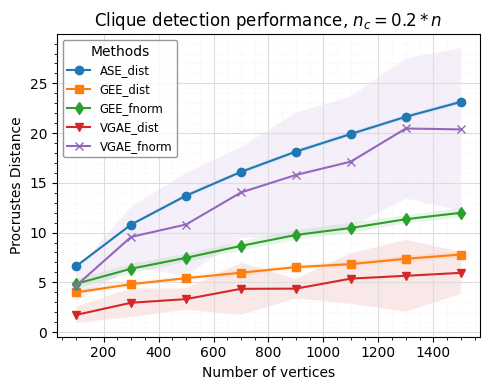

In [173]:
# CAUTION

fig, ax = plt.subplots(figsize=(5, 4))
#fig.patch.set_facecolor("#fafafa")
#ax.set_facecolor("#fafafa")

for item in [fig, ax]:
    item.patch.set_visible(True)

for variable, group in finaldf.groupby('variable'):
    ax.plot(group['n'], group['value_mean'], label=variable)
    ax.fill_between(group['n'], group['value_mean'] - group['value_std'], 
                    group['value_mean'] + group['value_std'], alpha=0.1)
    ax.grid(True)
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.minorticks_on()
    

ax.set(xlabel='Number of vertices', ylabel='Procrustes Distance', 
       title='Clique detection performance, $n_c = 0.2*n$')#+cliquesize)
# ax.set_facecolor("white")

# set markers
#markers = ['o', 's', 'd','v','x','8']
markers = ['o', 's', 'd','v','x']
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])

#ax.legend(ax.get_lines(), finaldf.columns, loc='upper left', ncol=2)

plt.tight_layout()

legend = plt.legend(frameon = 1,loc = 2,title="Methods",fontsize='small',fancybox=True )
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')

#plt.show()
#plt.savefig('./plots/rdm_diri_3rdpglogn' + cliquesize + '.png')


## generate norm of graph

In [378]:
nvs = np.arange(100, 1501, 200)
d = 2
sim = 50
random.seed(118)

adj0_norms = []
test_adj0norms = []
n_vs = []

for n in nvs:
    for i in range(sim):
#         lpvs = np.random.dirichlet((1,1,1),n) 
#         lpvs = np.delete(lpvs, 2, 1)
#         g = rdpg(lpvs,loops=False)
        
        latent, ys = latent3y(n)
        g = rdpg(latent,loops=False)
        g.astype(int)
        adj0 = csr_array(g)
        graph0 = nx.from_numpy_matrix(g,parallel_edges=False, create_using=None)
        
        adj0_norm = sp.linalg.norm(adj0)
        adj0_norms.append(adj0_norm)
        n_vs.append(n)
          
    sim_data = np.column_stack((adj0_norms,n_vs))
    sim_data = pd.DataFrame(sim_data, columns = ['adj0_norm','n'])
    
    df_id = n.astype(str)
    #sim_data.to_csv("./sim_data/new_sim/rdpg3_adj0_norms"+df_id+".csv", sep=',', index=False)
    
test_adj0norms.append(sim_data)


## singular 3 cluster

In [11]:
# clean code
# 3 rdpg
# singular values


nvs = np.arange(100, 1501, 200 )

sim = 50
random.seed(118)

ASE_dist = []
ASE_nml = []
GEE_dist = []
GEE_nml = []
GAE_dist = []
GAE_nml = []
n_vs = []

GEE_fnorm = []
GAE_fnorm = []

GEE_dist2 = []
GEE_fnorm2=[]

adj0_norms = []

singVs_A0 = []
singVs_A1 = []

A0_singvs = []
A1_singvs = []

sim_alldata_nml = []

for n in nvs:
    for i in range(sim):
#         lpvs = np.random.dirichlet((1,1,1),n) 
#         lpvs = np.delete(lpvs, 2, 1)
#         g = rdpg(lpvs,loops=False)

        latent, ys = latent3y(n)
        g = rdpg(latent,loops=False)
        
        g.astype(int)
        adj0 = csr_array(g)
        graph0 = nx.from_numpy_matrix(g,parallel_edges=False, create_using=None)
        
        adj0_norm = sp.linalg.norm(adj0)
        adj0_norms.append(adj0_norm)

        ########## find the clique vertices ##################################
        ratio = 0.2      
        cliquesize =f'{ratio}*n'     #!!    f'{ratio}*n'  f'log(n)^2'
        clique_size = ratio*n    #math.log(n)           #   ratio*n 
        num_vertices = int(clique_size) 
        #################  change location of vertices##################
        #c_vertices = np.arange(0,num_vertices)  
        #c_vertices = np.arange(n-num_vertices,n)  
        c_vertices = random.sample(range(0,n),num_vertices)
        ################################################################
        # generate the new latent position matrix with cliques
#         lpvs_c = np.empty((lpvs.shape[0], lpvs.shape[1] + 1), dtype=lpvs.dtype)
#         lpvs_c[:, :lpvs.shape[1]] = lpvs
#         lpvs_c[:,2] = 0
#         for i in c_vertices:
#             lpvs_c[i][2] = math.sqrt(1-lpvs[i][0]**2-lpvs[i][1]**2)
#             #print(lpvs_c[i])

        latent_c = np.empty((latent.shape[0], latent.shape[1] + 1), dtype=latent.dtype)
        latent_c[:, :latent.shape[1]] = latent
        latent_c[:,2] = 0
        for i in c_vertices:
            latent_c[i][2] = math.sqrt(1-latent[i][0]**2-latent[i][1]**2)
            #print(lpvs_c[i])         

        g2 = rdpg(latent_c,loops=False)
        g2.astype(int)
        #adj1 = csr_array(g2)
        graph1 = nx.from_numpy_matrix(g2,parallel_edges=False, create_using=None)
        adj1 = nx.to_numpy_array(graph1, dtype=int)

        ##############  ASE  ######################3
        d = 3
        ase = AdjacencySpectralEmbed(n_components=d, algorithm='truncated')
        ASE_Xhat0 = ase.fit_transform(adj0)

        ASE_Xhat1 = ase.fit_transform(adj1)

        #pairplot(Xhat0, title='2-component embedding', height=2)
        ASE_d = procrustes(ASE_Xhat1,ASE_Xhat0)
        ASE_d = ASE_d['error']
        ASE_dist.append(ASE_d)
        
        ASE_n = ASE_d/adj0_norm
        ASE_nml.append(ASE_n)

        ############ GEE ##################
        n_comms = 3
        edgelist0 = adj_to_edg(adj0)
        i_graph0 = ig.Graph.from_networkx(graph0)
        #y0 = la.find_partition(i_graph0, la.ModularityVertexPartition)
        #y0 = la.find_partition(i_graph0,la.CPMVertexPartition,resolution_parameter = 0.015)
        y0 = la.CPMVertexPartition(i_graph0,initial_membership=np.random.choice(n_comms, n),
                           resolution_parameter=0.5)
        label_num = []
        for k in range(len(y0)):
            y = len(y0[k])
            label_num.append(y)
        values = np.arange(len(label_num))
        label0 = np.repeat(values, label_num) 
        label0= label0.reshape((n,1))
        Z0,W0 = graph_encoder_embed(edgelist0,label0,n,correlation=False,emb_opt='AEE')

        edgelist1 = adj_to_edg(adj1)
        i_graph1 = ig.Graph.from_networkx(graph1)
        
        y1 = la.CPMVertexPartition(i_graph1,initial_membership=np.random.choice(n_comms, n),
                           resolution_parameter=0.5)
        
        label_num1 = []
        for j in range(len(y1)):
            y = len(y1[j])
            label_num1.append(y)
        values1 = np.arange(len(label_num1))
        label1 = np.repeat(values1, label_num1) 
        label1= label1.reshape((n,1))
        Z1,W1 = graph_encoder_embed(edgelist1,label1,n,correlation=False,emb_opt='AEE')

        GEE_d = procrustes(Z1,Z0)
        GEE_d = GEE_d['error']
        GEE_dist.append(GEE_d)
        
        GEE_n = GEE_d/adj0_norm
        GEE_nml.append(GEE_n)
        
        GEE_fd = np.linalg.norm(Z0 - Z1, "fro")
        GEE_fnorm.append(GEE_fd)
        
         
        
        ############### VGAE ################
        dim = 3
        features = torch.eye(n)
        model_GAE = GCNModelVAE(n, 2*dim, dim, 0) #init new instance everytime. Can change 0 to other dropout rates
        
        adj0 = nx.to_numpy_array(graph0, dtype=int)
        adj_norm_matrix0, adj_matrix0, adj_label0 = adj_in_out(adj0)
        GAE_0 = GCN_emb(model_GAE, features, adj_norm_matrix0, adj_label0,n,decay=0, learning_rate=1e-2) #initial benchmark: decay = 1e-3; investigate 0 weight decay w/ dropout on 
        GAE_0 = GAE_0.numpy()
        adj1 = nx.to_numpy_array(graph1, dtype=int)
        adj_norm_matrix1, adj_matrix1, adj_label1 = adj_in_out(adj1)
        GAE_1 = GCN_emb(model_GAE, features, adj_norm_matrix1, adj_label1,n,decay=0, learning_rate=1e-2) #initial benchmark: decay = 1e-3; investigate 0 weight decay w/ dropout on 
        GAE_1 = GAE_1.numpy()
        GAE_d = procrustes(GAE_1,GAE_0)
        GAE_d = GAE_d['error']
        GAE_dist.append(GAE_d)
        
        GAE_n = GAE_d/adj0_norm
        GAE_nml.append(GAE_n)
        
        GAE_fd = np.linalg.norm(GAE_0 - GAE_1, "fro")
        GAE_fnorm.append(GAE_fd)
        
        n_vs.append(n)
        
        ########################### get singular values of A0 and A1
        u0,s0,vh0 = np.linalg.svd(adj0,full_matrices=True)
        singVs_A0.append(np.append(s0[0:10],n))
        
        u1,s1,vh1 = np.linalg.svd(adj1,full_matrices=True)
        singVs_A1.append(np.append(s1[0:10],n))
        
           
    sim_data = np.column_stack((ASE_dist, GEE_dist,GAE_dist,
                                ASE_nml,GEE_nml,GAE_nml,n_vs,
                                GEE_fnorm,GAE_fnorm,adj0_norms))
    sim_data = pd.DataFrame(sim_data, columns = ['ASE_dist','GEE_dist','VGAE_dist',
                                                 'ASE_nml','GEE_nml','GAE_nml','n',
                                                 'GEE_fnorm','VGAE_Fnorm','adj0_norms'])
    
    df_id = n.astype(str)
    sim_data.to_csv("./sim_data/singular/rdpg3cluster_02n"+cliquesize+df_id+".csv", sep=',', index=False)

sim_alldata_nml.append(sim_data)
    
SV_A0 = np.reshape(singVs_A0,(sim*len(nvs),11))
SV_A1 = np.reshape(singVs_A1,(sim*len(nvs),11))
    
A0_singvs.append(SV_A0)
A1_singvs.append(SV_A1)

tt = np.reshape(A0_singvs,(sim*len(nvs),11))
singvalue_a0 = pd.DataFrame(tt)
singvalue_a0.to_csv("./sim_data/singular/3rdpgsing_A0_02n.csv", sep=',', index=False)

pp = np.reshape(A1_singvs,(sim*len(nvs),11))
singvalue_a1 = pd.DataFrame(pp)
singvalue_a1.to_csv("./sim_data/singular/3rdpgsing_A1_02n.csv", sep=',', index=False)

# print(sim_alldata_nml)
# print(A0_singvs)
# print(A1_singvs)


GCNModelVAE(
  (gc1): GraphConvolution (500 -> 6)
  (gc2): GraphConvolution (6 -> 3)
  (gc3): GraphConvolution (6 -> 3)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (500 -> 6)
  (gc2): GraphConvolution (6 -> 3)
  (gc3): GraphConvolution (6 -> 3)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (700 -> 6)
  (gc2): GraphConvolution (6 -> 3)
  (gc3): GraphConvolution (6 -> 3)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (1300 -> 6)
  (gc2): GraphConvolution (6 -> 3)
  (gc3): GraphConvolution (6 -> 3)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
